In [ ]:
import datetime
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

## Extract Data

In [ ]:
INPUT_DATA = "../data/POWER_Point_Hourly_20201231_20220101_000d8018N_127d9988E_LST.csv"

In [ ]:
with open(INPUT_DATA, "r") as f:
    text = ''
    texts = []
    nrows_header = 0
    while "-END HEADER-" not in text:
        text = f.readline()
        print(text.strip('\n'))
        texts.append(text)
        nrows_header += 1

-BEGIN HEADER-
NASA/POWER CERES/MERRA2 Native Resolution Hourly Data 
Dates (month/day/year): 12/31/2020 through 01/01/2022 
Location: Latitude  0.8018   Longitude 127.9988 
Elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 293.87 meters
The value for missing source data that cannot be computed or is outside of the sources availability range: -999 
Parameter(s): 
WS10M     MERRA-2 Wind Speed at 10 Meters (m/s) 
WD10M     MERRA-2 Wind Direction at 10 Meters (Degrees) 
WS50M     MERRA-2 Wind Speed at 50 Meters (m/s) 
WD50M     MERRA-2 Wind Direction at 50 Meters (Degrees) 
-END HEADER-


In [ ]:
df = pd.read_csv(INPUT_DATA,
                 skiprows=nrows_header)

for i, v in df['HR'].items():
    if v == 23:
        break

df = df[i+1:i-23].reset_index(drop=True)  # slice to start from 0 and end at 23
df['dt'] = df.apply(lambda row: datetime.datetime(int(row.YEAR),
                                                  int(row.MO),
                                                  int(row.DY),
                                                  int(row.HR)), axis=1)
df = df[['dt', 'WS10M', 'WS50M']].set_index('dt')
df.head()

,WS10M,WS50M
dt,,
2021-01-01 00:00:00,2.76,4.31
2021-01-01 01:00:00,2.77,4.34
2021-01-01 02:00:00,2.77,4.35
2021-01-01 03:00:00,2.74,4.28
2021-01-01 04:00:00,2.76,4.25


## `Pandas.DataFrame` Cubic Polynomial Interpolation

In [ ]:
df_upsampled = df.resample('10Min').mean().interpolate(method='cubic', order=3)
df_upsampled.head(20)

,WS10M,WS50M
dt,,
2021-01-01 00:00:00,2.760000,4.310000
2021-01-01 00:10:00,2.759751,4.311048
2021-01-01 00:20:00,2.760648,4.314454
2021-01-01 00:30:00,2.762406,4.319635
2021-01-01 00:40:00,2.764740,4.326008
2021-01-01 00:50:00,2.767367,4.332990
2021-01-01 01:00:00,2.770000,4.340000
2021-01-01 01:10:00,2.772355,4.346454
2021-01-01 01:20:00,2.774148,4.351770


## Save

In [ ]:
df_upsampled['YEAR'] = df_upsampled.apply(lambda row: row.name.year, axis=1)
df_upsampled['MO'] = df_upsampled.apply(lambda row: row.name.month, axis=1)
df_upsampled['DY'] = df_upsampled.apply(lambda row: row.name.day, axis=1)
df_upsampled['HR'] = df_upsampled.apply(lambda row: row.name.hour, axis=1)
df_upsampled['MIN'] = df_upsampled.apply(lambda row: row.name.minute, axis=1)
df_upsampled = df_upsampled[['YEAR', 'MO', 'DY', 'HR', 'MIN','WS10M', 'WS50M']]
df_upsampled

,YEAR,MO,DY,HR,MIN,WS10M,WS50M
dt,,,,,,,
2021-01-01 00:00:00,2021,1,1,0,0,2.760000,4.310000
2021-01-01 00:10:00,2021,1,1,0,10,2.759751,4.311048
2021-01-01 00:20:00,2021,1,1,0,20,2.760648,4.314454
2021-01-01 00:30:00,2021,1,1,0,30,2.762406,4.319635
2021-01-01 00:40:00,2021,1,1,0,40,2.764740,4.326008
...,...,...,...,...,...,...,...
2022-01-01 22:20:00,2022,1,1,22,20,3.585813,5.498216
2022-01-01 22:30:00,2022,1,1,22,30,3.567826,5.481492
2022-01-01 22:40:00,2022,1,1,22,40,3.553655,5.468881


In [ ]:
with open(f"{INPUT_DATA[:-4]}_upsampled.csv", 'w') as f:
    for text in texts:
        if 'WD' not in text:
            f.write(text)

    df_upsampled.to_csv(f, index=False, line_terminator='\n')

## Sample Plot Comparison

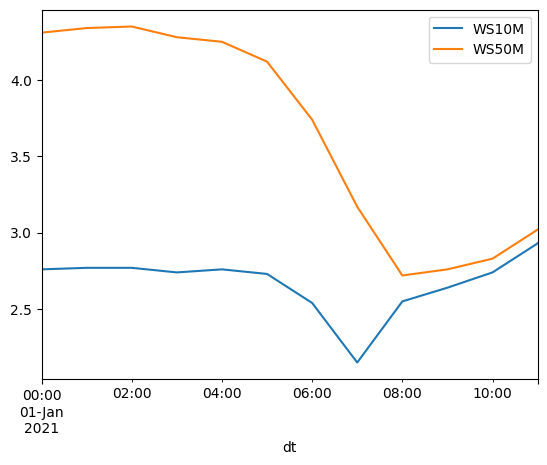

In [ ]:
df[:12].plot()
plt.show()

<AxesSubplot:xlabel='dt'>

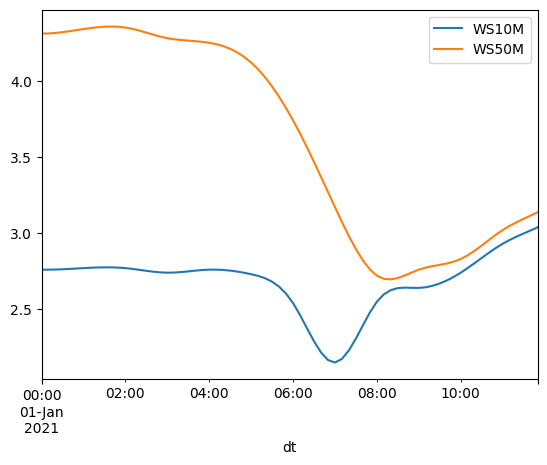

In [ ]:
df.resample('10Min').mean().interpolate(method='polynomial', order=3)[:6*12].plot()
plt.show()

<AxesSubplot:xlabel='dt'>

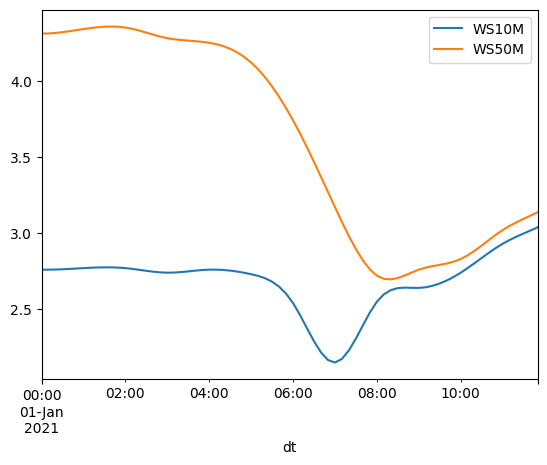

In [ ]:
df.resample('10Min').mean().interpolate(method='cubic')[:6*12].plot()

<AxesSubplot:xlabel='dt'>

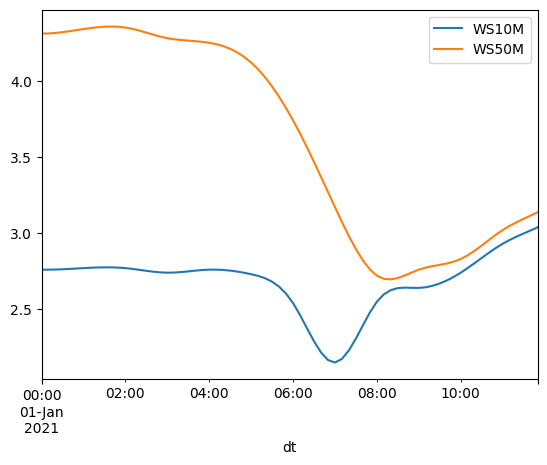

In [ ]:
df.resample('10Min').mean().interpolate(method='spline', order=3, s=0.)[:6*12].plot()
plt.show()

## Notes

From the [doc](https://docs.scipy.org/doc/scipy-1.7.1/reference/reference/generated/scipy.interpolate.interp1d.html):

'cubic' refer to a spline interpolation of third order 

In [ ]:
import scipy
import pandas as pd

In [ ]:
scipy.__version__, pd.__version__

('1.7.3', '1.3.5')